# **Analyse the New York City Street Network!**

# Table of Contents

1. Introduction
2. Fundamental Graph Theory
3. Network Properties
4. Network Robustness
5. Community Detection
6. Application: Competition 
7. Summary and Outlook
8. References

# 1. Introduction

## 1. Introduction

This research focuses on using methodologies of network analysis to slove a sequence of questions. The dataset is from kaggle: Street Network of New York in GraphML. Our research target is to gain a further understanding of why some taxis have a longer trip than others, how to calculate the shortest path between the pickup and dropoff point and given that, which Boroughs and Neighborhoods does the taxi traverse, and are there any sensitive roads during a trip which may cause the taxi to spend more time on it.

The rest of this research is structured as follows: 
1. We take a look at some basic properties of the network, like how big is the network.
2. Dig deeper to explore the generative process of the network and which roads may be important in a sense of high traffic volume and under the aspect of road closures aka attacks.
3. We will calculate useful features for the competition, like shortest paths and which boroughs it passes.

![](http://i.imgur.com/6YJ6gV3.jpg)

# 2. Fundamental Graph Theory

In this section, some basic notions of graph theory will be introduced. Then, we will further explain these fundamental theories in the New York City Street Graph.

The first question is, what is a graph?

A graph **G = (V, E)**  consists of a set of **nodes** V ( or vertices, points)  and a set of **edges**  E ( links, lines) which illustrate how the nodes in the network are interacting with each other. Edges can be **directed** or **undirected**. The number of nodes **N** is often called the **size** of the network. In this example, nodes are represented by way points in the OSM map from which the graph was generated. Edges are roads or sub parts of roads between two nodes.

What we mentioned above is the simplest model of a graph. Edges, however, can add weight coefficients. One available example is the road map, and each road has a particular length. So when you simplify the road map into a graph, the weight of the edge represents the length of the corresponding road. An graph with weighted edges is called an **weighted graph**.

The first measurement for a node in the graph is the so called **degree**, which stands for the number of edges it has to other nodes, denoted by *k*. One can also might ask what is the average degree in the network? But wait a second... if the degree is the number of edges it has to other nodes, don't we have to distinguish between directed and undirected edges to calculate the degree? Indeed, we need to distiguish between the **In-degree** and the **Out-degree** of a node, simply measuring how many edges are leaving a node and how many edges are coming in. This of cource depends on if the graph is direted or not. In the case of an undirected graph we can calculate the **average degree** by the following formular:

$$ \overline{k} = \frac{1}{N} \sum_{i = 1}^N k_i = \frac{2E}{N}$$

When a graph is directed, the degree can be done seperatly for the in and out:

$$ k_{in} = \frac{1}{N} \sum_{i = 1}^N k_{in}^i =k_{out} = \frac{1}{N} \sum_{i = 1}^N k_{out}^i =  \frac{E}{V}$$

because $$k_i = k^{out}_i  + k^{in}_i  $$

Let's have a look at the network, and the basic properties of it. First we need to load the graph. (Some basic python packages need to be imported.)

In [1]:
#For later use
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import networkx as nx
warnings.filterwarnings('ignore')

#load the graph with nx.read_graphml
G = nx.read_graphml('input/street-network-of-new-york-in-graphml/manhatten.graphml')

In [2]:
nx.info(G)

"MultiDiGraph named 'Manhattan, New York, USA' with 4426 nodes and 9626 edges"

The graph has *4426* nodes and *9626* edges so the size of the network is *4426* and it states that it is an MultiDIGraph, which means the edges of the graph are **directed**, so they point to a specific node in the network. 

Why is this so? Because our Network is the Manhattan Street Network and one property of it is that it contains one-way streets which can only be modeled as directed edges. Because we represent the edges as directed each 'normal' street is now also modeled as a directed edge which means we need to introduce two edges for each normal street, one for each direction of the street.

 On average the In-degree is *2.6257* and the out-degree is also *2.6257*, both are the same just as discussed. Average In-degree and Out-degree are always the same, nevertheless the distribution of the individual degrees can vary. A graph is often called **simple graph**, if it contains no self-loops and directed edges. Here we use the tool in "networkx" to simplify the directed graph. Please see the following cell.

In [3]:
G_simple = nx.Graph(G)
nx.info(G_simple)

"Graph named 'Manhattan, New York, USA' with 4426 nodes and 7886 edges"

Interesting! The number of nodes is still *4426* but the number of edges is decreased to only *89618* edges. Also the degree went up to *3.56*. The average degree of the simple graph is not the add of in and out degree, which is because the edges between two nodes are merged into one edge when it is simplified.

Then let's have a look on the distribution of the node degress of this graph for simplified network as for the directed case.

In [4]:
degree_list = []
for data in G.degree():
    degree_list.append(data[1])

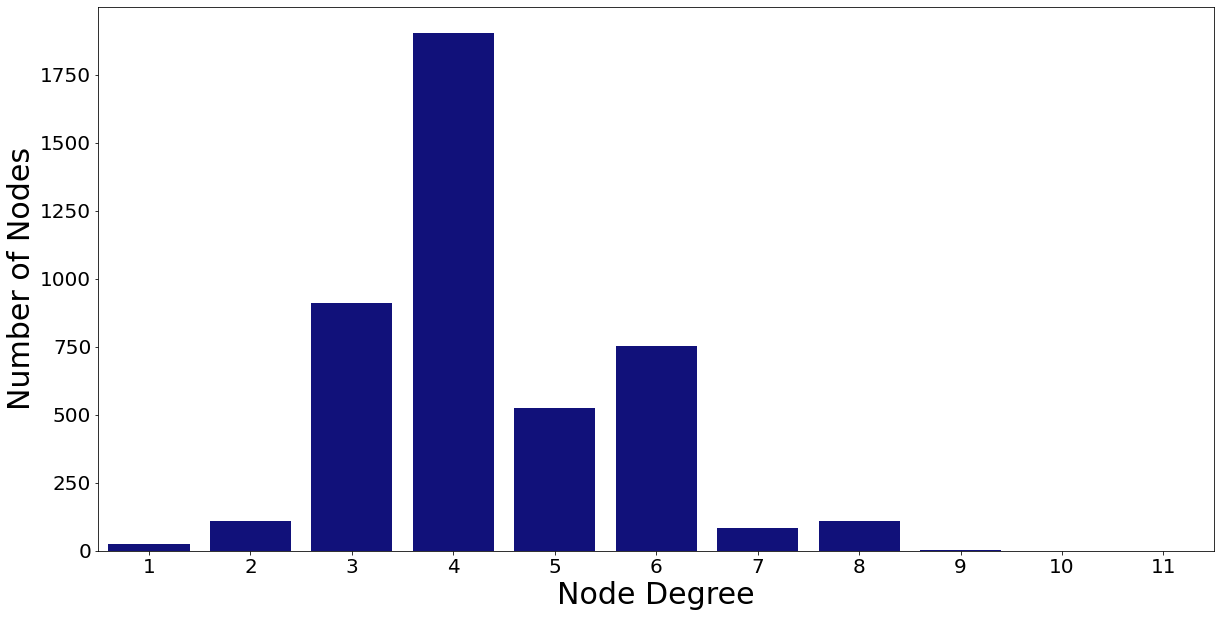

In [5]:
from collections import Counter
degree_dic = Counter(degree_list)

degree_hist = pd.DataFrame({"degree": list(degree_dic.values()),
                            "Number of Nodes": list(degree_dic.keys())})
plt.figure(figsize=(20,10))
sns.barplot(y = 'degree', x = 'Number of Nodes', 
              data = degree_hist, 
              color = 'darkblue')
plt.xlabel('Node Degree', fontsize=30)
plt.ylabel('Number of Nodes', fontsize=30)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.show()

Ok, so most of the nodes tend to have a degree of *3* or *4* which comes from the grid like structure of Manhattan. And this is confirmed by plotting the distributions for the directed case, most nodes with 2 outgoing edges have also two incoming edges!

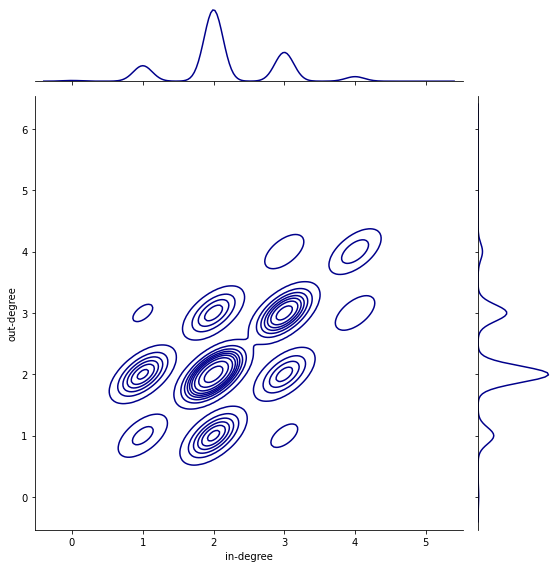

In [6]:
ins = []
outs = []

for data in G.in_degree():
    ins.append(data[1])
for data in G.out_degree():
    outs.append(data[1])
degrees = pd.DataFrame({"in-degree": ins, "out-degree": outs})

fig = sns.jointplot(x="in-degree",y="out-degree",data=degrees,kind="kde", color = 'darkblue',size=8)


Given the number of nodes and edges one can ask, what is the structure of the network and how does it look like?
The first measure of the network structure is the so called **density** which measure how many links from all possible links within the network are realized. The density is *0* if there are no edges, called **empty graph** and *1* if we have a **complete Graph**, all possible links between nodes are established.

Assuming the number of nodes in a graph is *N*. If the graph is an undirected one, it is easy to tell that the maximum number of edges is:

$$ \frac{N(N-1)}{2} $$

However, if the graph is a directed one, the maximum number of the edges will be changed to:

$$ N(N-1) $$

Hence, we can get the density of each kind of graph:

$$dens_{undirected} = \frac{2E}{N(N-1)}$$

$$dens_{directed} = \frac{E}{N(N-1)}$$


In [7]:
nx.density(G)

0.0004914973410841433

Having a density of *0.00049* makes sense because in a street network not all nodes can be connected to all other nodes.  Enough text for now, let's plot the graph!

In [9]:
import osmnx

ModuleNotFoundError: No module named 'osmnx'

In [ ]:
ox.plot_graph(G,fig_height= 12, node_size=10, node_zorder=2, node_color = '#808080')

![](http://i.imgur.com/N9RIXA2.png)

The above picture gives us an overview of how Manhattan looks like. But such awesome figures like this made with osmnx are not always the case. If we plot the graph with the build in draw function from networkx, our nodes are just plotting according to some layout we choose:

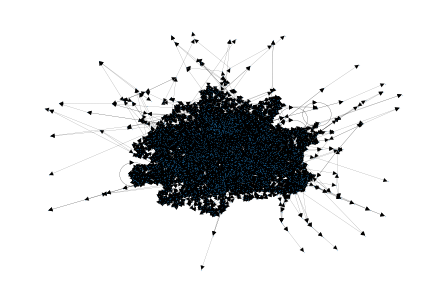

In [8]:
nx.draw(G, pos=nx.spring_layout(G), node_size=0.01, width=0.1)

This graph picture doesn't look much like above ones.

# 3. Network Properties

In this section we will talk about some basic measurements which will give us some feedback about the structure of the graph. This will include what is the average shortest path distance between nodes, in which way are the nodes in the network connected to each other and how strong is the connection between a node and his neighbours.

We will start by defining what the **shortest path** between two nodes *i* and *j*  in the network is. 
The shortest path $d(i,j)$, as the name suggests, is just the path in the network between nodes  *i* and *j* which has the fewest edges. In the case of an undirected network, the shortest path between *i* and *j* is always the same regardless from which node we start, however in an directed network this does not hold true and the shortest path between the nodes can vary depending from which node we start. On the bases of the shortest path we can define many more measurements, e.g., the longest shortest path in the network is called the **diameter** of the graph and gives us a feeling of how far things are seperated in the graph. We will compute the diameter on the simple graph for computation time.


In [9]:
nx.diameter(G_simple)

88

The function returns a number of *88* edges which lie on the longest shortest path.
Besides the longest shortest path, we can also ask what is the average shortest path length denoted by: 

$$ a =  \sum_{i ,j \in E} \frac{d(i,j)}{N(N-1)}$$

where $d(i,j)$  is the shortest path.

In [10]:
nx.average_shortest_path_length(G_simple)

35.046706033428556

Coming back to the question of what is the structure of our network. Is the network random, or does it follow some underlying laws on how it is created?

Here we introduce the **Scale-Free Property**, which states that 'real' networks do have a certain underlying creation process, like the WWW (world wide web) there some nodes do get more attention than others and therefore manage to build much more edges than other nodes., resulting in some nodes which have a much higher degree compared to other nodes. 

These nodes with a very high degree in the network are called **hubs**. One can think of Twitter as a Social Network there prominent people represent hubs, having much more edges to other nodes than the average user.
But does our network follow the Scale-Free Property because it is a 'real' network? Let's plot the degree distributions to find out!

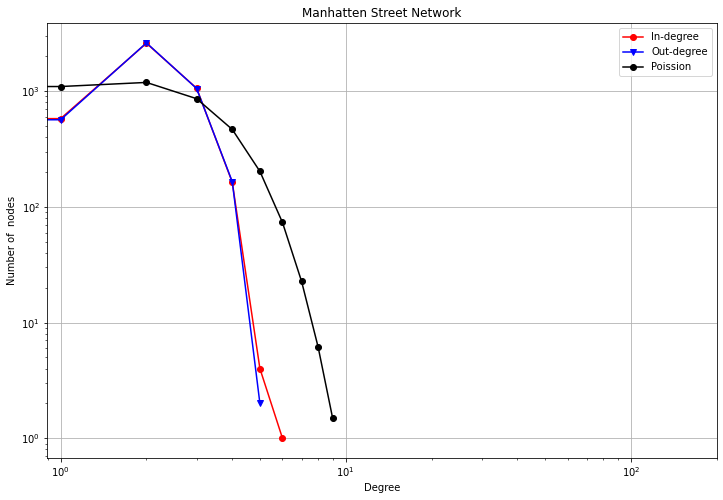

In [14]:
from collections import Counter
import collections
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt

in_degrees  = G.in_degree()
in_degrees_list = []
for data in in_degrees:
    in_degrees_list.append(data[1])
in_h = Counter(in_degrees_list)
in_dic = collections.OrderedDict(sorted(in_h.items()))
in_hist = list(in_dic.values())
in_values =list(in_dic.keys())

out_degrees  = G.out_degree()
out_degrees_list = []
for data in out_degrees:
    out_degrees_list.append(data[1])
out_h =  Counter(out_degrees_list)
out_dic = collections.OrderedDict(sorted(out_h.items()))
out_hist = list(out_dic.values())
out_values =list(out_dic.keys())

mu = 2.17
sigma = sp.sqrt(mu)
mu_plus_sigma = mu + sigma
x = range(0,10)
prob = stats.poisson.pmf(x, mu)*4426

plt.figure(figsize=(12, 8)) 
plt.grid(True)
plt.loglog(out_values,out_hist,'ro-')  # in-degree
plt.loglog(in_values,in_hist,'bv-')  # in-degree
plt.plot(x, prob, "o-", color="black")
plt.legend(['In-degree','Out-degree','Poission'])
plt.xlabel('Degree')
plt.ylabel('Number of  nodes')
plt.title('Manhatten Street Network')
plt.xlim([0,2*10**2])
plt.show()


If a graphs degree distribution follows the scale free property on a log-log scale plot like above, the data points should form approximately a straight line indicating the presents of hubs. In our figure in the cell above this is clearly not the case. As already plotted, the degree distributions follow a Poisson Distribution which is typical for a random network. 

So what can we say about the Manhattan Street Network? It has more edges than nodes, and the fact that it is not scale-free means the absents of hub nodes and it follows a Poisson Distribution like random networks do.

Now we can ask the question, is it good for a road network that its degree distribution does not have the scale free property and is even random? How does this influences the **robustness** of the network in a sense that what happens if specific roads are closed, how does this influnces the traffic flow?

In the following section, we will focus on this question.



# 4. Network Robustness

What does it take to break down  all the movement in Manhattan? What roads are sensible in a sense that if these roads are closed the impact on the whole network traffic flow is drastic. Network Robustness tries to define measurements which try to capture how robust  a network is to attacks, failures or something like a traffic jam. 

In this section some basic measurements will be introduced and tested on the Manhattan subgraph.



### Node Connectivity

The **Node Connectivity** describes the number of nodes we must delete from the Graph G until it is **disconnected**. **Connected** means that if every node in our graph G can reach any other node in the network via edges. If this is not the case the graph is disconnected. An important property of any graph should to be that it is not easily to disconnect. This is some kind of vague definition, especially for a road network  as there might be dead-end roads, removing the connecting node of the dead-end would immediately make our graph G disconnected. 

Here it is time in introduce also the notation of a **simple graph** which is a graph without directed edges or self-loops.  Many measurements in libraries are only calculated on simple graphs because it simplifies calculations or the measurements are just not defined on directed graphs.

For the next few sections we treat our graph as undirected to illustrate these measurements:

In [15]:
#create two simple graphs from our original directed graph
G_simple = nx.Graph(G)
G_simple2 = nx.Graph(G)


nx.node_connectivity(G_simple)

1

As aspected the output of  the node connectivity function is 1, meaning our graph is disconnected after removing just 1 node. But does this matter? No, because the size of the removed subgraph is just a single node and the rest of the network is still connected. If however the size of the resulting disconnected part is relatively big, this indicates a problem in the structure of the network.

### Algebraic Connectivity

Basically our network is nothing else as a matrix containing 1's if two nodes are connected to each other.
Graphs can be differently defined as matrices and one of these matrices is the so called Laplacian matrix, which has special properties in the eigenspace. Its eigenvalues are non negative and if ordered the smallest one eigenvalue is zero. The second smallest eigenvalue of the Laplacian matrix is called the **algebraic connectivity** or the **Fiedler value**. It is directly indicater for the robustness of the network have the properties that:
 

 1. The algebraic connectivity is equal to zero if and only if the graph is disconnected.
 2. The algebraic connectivity of an  graph is not greater than the node connectivity. 

In [16]:
nx.algebraic_connectivity(G_simple)

0.00034232718225941065

According to its properties we can say, that the graph is connected because the algebraic connectivity is *0.00034* and < node connectivity.

### Betweenness Centrality

Betweenness Centrality can be measure for nodes or edges and it defines the fraction of all shortest paths in the network passing through the edge/ node for which it is calculated.  

Roads with a very high betweenness centrality lie on many shortest paths in the network and should be considered to be important roads in the network which may have increased traffic volume. 


In [17]:
#compute the betweeness centrality on one of the simple graphs, this can take a while
between =  nx.betweenness_centrality(G_simple)

In the cell above we created two simple graphs and calculated the betweeness-centrality for each node in the network. We can now tell which nodes in the network play an important role as they are traversed more often. Let's find out which is on the most shortest path in the network: 

In [ ]:
#G_projected = ox.project_graph(G)
#max_node, max_bc = max(between.items(), key=lambda x: x[1])
#max_node, max_bc

(42431099, 0.2170387058765219)

In Manhatten the node with ID 42431099 has  the highest betweenness centrality and 21.7% of all shortest paths running through it. This needs to be plotted!

![](http://i.imgur.com/fnNk9Zf.png)

In [19]:
G['42431099']

AdjacencyView({'42431096': {0: {'osmid': '[420623126, 420623127]', 'geometry': 'LINESTRING (-73.9732066 40.7952534, -73.9735549 40.7948043, -73.97372439999999 40.7945858)', 'length': '86.0848219588', 'oneway': 'False', 'highway': 'secondary', 'name': 'West End Ave.', 'key': 0}}, '587812578': {0: {'osmid': '195743218', 'geometry': 'LINESTRING (-73.9732066 40.7952534, -73.97473549999999 40.795896, -73.97531119999999 40.7961379)', 'length': '202.633464412', 'oneway': 'False', 'highway': 'secondary', 'name': 'West 96th Street', 'key': 0}}, '42428714': {0: {'lanes': '3', 'name': 'West 96th Street', 'geometry': 'LINESTRING (-73.9732066 40.7952534, -73.9728566 40.7951057, -73.9722601 40.7948539, -73.9719192 40.7947101)', 'length': '124.074738833', 'oneway': 'False', 'highway': 'secondary', 'osmid': '[420623122, 420623123, 68668555]', 'key': 0}}, '42431102': {0: {'osmid': '[420623128, 195743223]', 'geometry': 'LINESTRING (-73.9732066 40.7952534, -73.9730055 40.795531, -73.9727152 40.7959319)',

The above output is the information of that particular node. And we can tell that the node  with the highest betweenness centrality is located in West End.

Now it may be interesting so see how all nodes betweenness centrality looks an one map and maybe there are some patterns  to detect! We plot the centrality for each node from low (dark violet) to high (light yellow).

As can be seen from the route map of Manhattan, the points with high centrality are mostly distributed on both sides of Central Park. This is because there is no way to connect central Park. At the same time, these areas also play the role of carrying the task of connecting Manhattan and Brooklyn, so they have a high centrality.

![](http://i.imgur.com/BfvPPMS.png)

![](http://i.imgur.com/aSCjx77.jpg)

# Network Attacks

Now we know some basic robustness measurements, so it is time to see how robust is our network really?
For this we will attack the networks nodes with two approaches:

 1.  Delete nodes according to the calculated betweenness centrality, going from high scoring nodes to low scoring ones 
 2.  Random node failures, deleting nodes by random

Deleting nodes will have the effect that the **giant component**, the largest connected component in the graph, will shrink and some nodes might have a specific role in this process which cause a drastic shrinkage of the giant component.


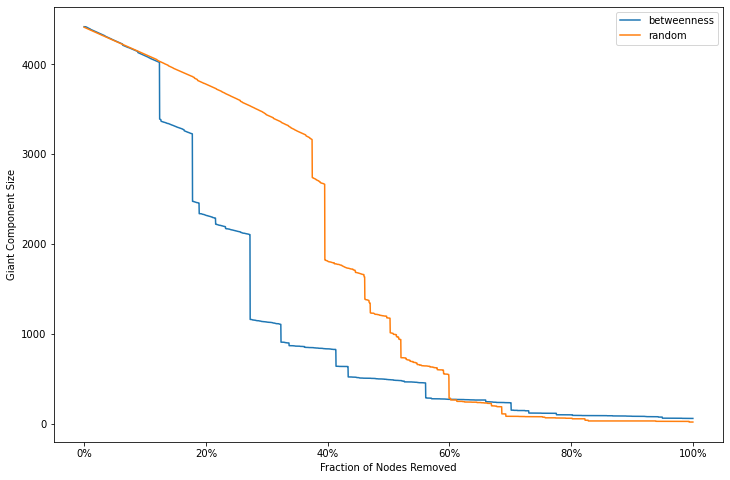

In [24]:
import operator
from random import shuffle
from random import randrange
from random import randint
import random
import matplotlib.ticker as mtick

sorted_x = sorted(between.items(), key=operator.itemgetter(1), reverse=True)
rand_x = list(range(0,4426 ))

random.shuffle(rand_x)
between_giant = []
between_rand = []
avg_degs = []

for x in range(3000):
 
        remove = sorted_x[x]      
        remove2 = sorted_x[rand_x[x]]
        G_simple.remove_nodes_from(remove)
        G_simple2.remove_nodes_from(remove2)
        
        giant = len(max((G_simple.subgraph(c) for c in nx.connected_components(G_simple)), key=len))
        giant2 = len(max((G_simple2.subgraph(c) for c in nx.connected_components(G_simple2)), key=len))
        
        #giant = len(max(nx.connected_component_subgraphs(G_simple), key=len))
        #giant2 = len(max(nx.connected_component_subgraphs(G_simple2), key=len))

        between_giant.append(giant)
        between_rand.append(giant2)

y1 = between_giant
y2 = between_giant

y1= y1[ :-1]
y2= y2[1: ]

perc = np.linspace(0,100,len(between_giant))
fig = plt.figure(1, (12,8))
ax = fig.add_subplot(1,1,1)

ax.plot(perc, between_giant)
ax.plot(perc, between_rand)

fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
xticks = mtick.FormatStrFormatter(fmt)
ax.xaxis.set_major_formatter(xticks)
ax.set_xlabel('Fraction of Nodes Removed')
ax.set_ylabel('Giant Component Size')
ax.legend(['betweenness','random'])
plt.show()

First of all, deleting nodes which play an important role in the network leads to a faster shrinkage of the giant component than just deleting nodes by random! But only at a given percentage level! At the beginning it doesn't matter if the nodes are picked at random or by their importance, this indicates the robustness of the network. However, at a point there about 10 percent of the nodes are removed deleting specific important nodes lead to a much faster reduction in the giants component size. So these nodes must play an important role in combining the nodes of the network!

Interestingly after only deleting about 50% of the nodes the size of the giant component rapidly reaches a size of almost zero nodes. 

# 5. Community Detection

This section introduces Community Detection. The goal of Community Detection is to find subgraphs aka communities in a given graph which we want to analyse.

We start by defining what exactly is a community? Well, there is no 'one' or 'right' defintion of community, because it really depends on the kind of graph you want to analyse and what question you want to answer. A common definition based on the graphs structure is, that a community is a group of nodes which are higly connected within this group, but are less connected to other nodes which are not in this group. But as said this is not the only definition you can use, sometimes you can define communities based on a given node attribute or a combination of both, graph based and attributes. 

For this section we will use the infamous [Zachary's karate club](https://en.wikipedia.org/wiki/Zachary%27s_karate_club) network, because it is less computional expensive and also very easy to draw. The short story behind the network is, that a conflict between an instructor and an admin led to the split of the club into two seperate ones. 

Because the networkx library is not so convenient for community detection, we will switch to igraph for this section, which has more algorithms for this topic, but first we have a look at the network!


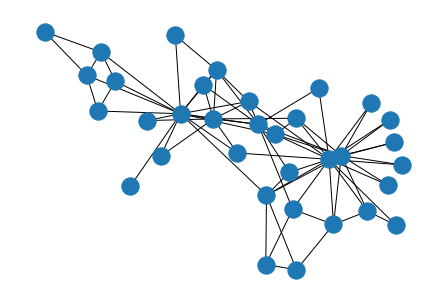

In [25]:
import networkx as nx
import matplotlib.pyplot as plt
import igraph as ig
import random
np.random.seed(3)

G1=nx.karate_club_graph()
nx.draw_spring(G1)

Most of the existing community detection algorithms work only on undirected graphs, so we will convert the networkx graph to igraph and also make it undirected.

In [26]:
#convert from networkx to igraph 
G2 = ig.Graph.Adjacency((nx.to_numpy_matrix(G1) > 0).tolist())

#make the igraph graph undirected :D
G2.to_undirected()

In the following we will discuss a bunch of algorithms which are more or less used in practice.

### Girvan–Newman algorithm

GN algorithm is used for community discovery algorithm. It was Girvan Newman, a combination of the authors' names.
The general idea of the algorithm is as follows:

Calculate the Betweeness value of each edge, then delete the edge with the highest value, then re-calculate the betweeness value of each edge at this time, then delete the highest edge again, and repeat until the number of connected branches reaches our requirement. (Connected branches are communities.)

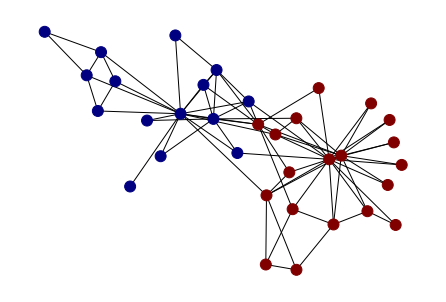

In [27]:
np.random.seed(3)

dendrogram = G2.community_edge_betweenness()
# convert it into a flat clustering
clusters = dendrogram.as_clustering(2)
# get the membership vector
membership = clusters.membership

nx.draw_spring(G1, cmap = plt.get_cmap('jet'), node_color = membership, node_size=120, with_labels=False)

### Modularity Maximization

Our goal is to find a measure that quantifies how many edges lie within groups in our network relative to the number of such edges expected on the basis of chance. A good division of nodes into communities is one that maximizes such a measure. Equivalently, we want a measure that quantifies how many edges lie between groups in our network relative to the expected number of such links. A good division of nodes into communities is one that minimizes such a measure. We will concentrate on the former measure of modularity of a network.

Let us focus on undirected multi-graphs, that is, graphs that allow self-edges (edges involving the same node) and multi-edges (more than one simple edge between two vertices). A measure of modularity of a network is the number of edges that run between vertices of the same community minus the number of such edges we would expect to find if the configuration model is assumed, that is if edges were positioned at random while preserving the vertex degrees. Let us denote $c_i$ the community of vertex $i$ and $\delta (c_i,c_j)=1$ if $c_i=c_j$ and $\delta (c_i,c_j)=0$ otherwise. Hence, the number of edges that run between vertices of the same group is:

$$ \sum_{(i,j)\in E}\delta (c_i,c_j)=\frac{1}{2}\sum_{i,j}A_{i,j}\delta(c_i,c_j) $$
where $E$ is the set of edges of the graph and $A_{i,j}$ is the actual number of edges between $i$ and $j$, which is zero or more (notice that each undirected edge is represented by two pairs in the second sum, hence the factor one-half).

The expected number of edges that run between vertices of the same group is:
$$ \frac{1}{2}\sum_{i,j}\frac{k_ik_j}{2m}\delta(c_i,c_j) $$
where $k_i$ and $k_j$ are the degrees of $i$ and $j$, while $m$ is the number of edges of the graph. Notice that the $k_ik_j/2m$ is the expected number of edges between vertices $i$ and $j$ in the configuration model assumption. Indeed, consider a particular edge attached to vertex $i$. The probability that this edge goes to node $j$ is $k_j/2m$, since the number of edges attached to $j$ is $k_j$ and the total number of edge ends in the network is $2m$ (the sum of all node degrees).Since node $i$ and $k_i$ edges attached to it, the expected number of edges between $i$ and $j$ is $k_ik_j/2m$.

Hence the difference between the actual and expected number of edges connecting nodes of the same group, expressed as a fraction with respect to the total number of edges $m$, is called modularity, and given by:
$$ Q=\frac{1}{2m}\sum_{i,j}\left(A_{i,j}-\frac{k_ik_j}{2m}\right)\delta(c_i,c_j)=\frac{1}{2m}\sum_{i,j}B_{i,j}\delta(c_i,c_j) $$

The modularity $Q$ takes positive values if there are more edges between same-group vertices than expected, and negative values if there are less. Our goal is to find the partition of network nodes into communities such that the modularity of the division is maximum. Unfortunately, this is a computationally hard problem. It is believed that the only algorithms capable of always finding the division with maximum modularity take exponentially long to run and hence are useless for all but the smallest of networks. Instead, therefore, we turn to heuristic algorithms, algorithms that attempt to maximize the modularity in an intelligent way that gives reasonably good results in a quick time.

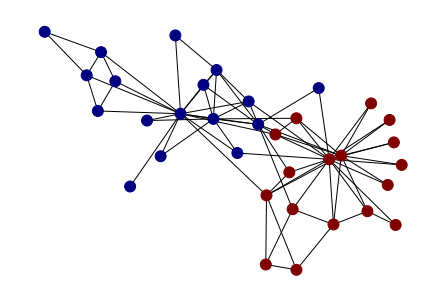

In [28]:
np.random.seed(3)

dendrogram = G2.community_fastgreedy()
# convert it into a flat clustering
clusters = dendrogram.as_clustering(2)
# get the membership vector
membership = clusters.membership

nx.draw_spring(G1, cmap = plt.get_cmap('jet'), node_color = membership, node_size=120, with_labels=False)

### Leading Eigenvector

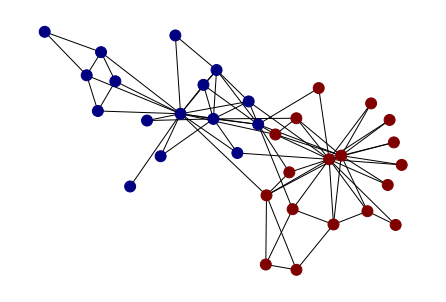

In [29]:
np.random.seed(3)

dendrogram = G2.community_leading_eigenvector(2)
#get membership
membership  = dendrogram.membership


nx.draw_spring(G1, cmap = plt.get_cmap('jet'), node_color = membership, node_size=120, with_labels=False)

# 6. Application: Competition 

In this last Section we will see how to compute the shortest path for our taxi trip data and how to add one could possible make use of all kind of centrality measures as features.

## Shortest Paths

First of all we need two functions which will compute the nearest node in the network for a given taxi pick-up and or drop-off point

In [30]:
#taken from. https://github.com/gboeing/osmnx
def great_circle_vec(lat1, lng1, lat2, lng2, earth_radius=6371009):

    phi1 = np.deg2rad(90 - lat1)

    phi2 = np.deg2rad(90 - lat2)

    theta1 = np.deg2rad(lng1)
    theta2 = np.deg2rad(lng2)

    cos = (np.sin(phi1) * np.sin(phi2) * np.cos(theta1 - theta2) + np.cos(phi1) * np.cos(phi2))
    arc = np.arccos(cos)

    distance = arc * earth_radius
   
    return distance


def get_nearest_node(G, point, return_dist=False):

    coords = np.array([[node, data['x'], data['y']] for node, data in G.nodes(data=True)])
    df = pd.DataFrame(coords, columns=['node', 'x', 'y']).set_index('node')
    df['reference_y'] = point[0]
    df['reference_x'] = point[1]

    distances = great_circle_vec(lat1=df['reference_y'],
                                 lng1=df['reference_x'],
                                 lat2=df['x'].astype('float'),
                                 lng2=df['y'].astype('float'))
  
    nearest_node = int(distances.idxmin())
  
    if return_dist:
        return nearest_node, distances.loc[nearest_node]
    else:
        return nearest_node

In [33]:
#load the training data
train = pd.read_csv('input/nyc-taxi-trip-duration/train.csv')


#go through the dataset and calculate the shortest path
for index, row in train[24:25].iterrows():

    pick_point = ( row['pickup_longitude'],row['pickup_latitude'])
    drop_point = ( row['dropoff_longitude'],row['dropoff_latitude'])
    
    pick_node = get_nearest_node(G, pick_point)
    drop_node = get_nearest_node(G, drop_point)
   
    try:
        route = nx.shortest_path(G, str(pick_node), str(drop_node))
        #plot the shortest path on the graph
        #fig, ax = ox.plot_graph_route(G, route,fig_height=15, node_size=1)
        print("Shortest Path:")
        print(route)
        gsub = G.subgraph(route)
        
        s_len = sum([float(d['length']) for u, v, d in gsub.edges(data=True)])
        print("Length in Km:")
        print(s_len/1000)
        
    except:
        print("Some Error")
        #handle error
        pass
    
    #the corresponding node betweenness scores for each edge in the shortest path
    print("Betweenness Centrality for each node on the path")
    node_bet = []
    for node in route:
        node_bet.append(between[node])
    print(node_bet)
    print(np.asarray(node_bet).sum())
    print("betweeness sum")
    print(sum(node_bet))

Shortest Path:
['42448238', '42435514', '42450028', '42447132', '42458766', '596776132', '42446036', '42449187', '42433927', '42435310', '42443353', '42442480', '42434160', '1061531637', '1061531810', '1061531768', '1061531682', '1061531731', '42428695', '42431067', '42441535', '595314125', '42425348', '2029349908', '595314119', '42441382', '42441310', '5004570627', '5004570651', '42452276', '5004570644', '5004570630', '42428814', '561035335', '627905367', '1506445762', '1504153604', '561035338', '1506599378', '1506599377', '561035342', '561035343', '561035344', '561035345', '561035346', '561035347', '42428880', '42434105', '42424679', '42424698', '587934347', '42424823', '60928432', '60927650', '60928040', '60916829', '595729853', '374482644', '374472690', '42441000', '42441007', '42441009', '595729838', '42429215', '42429216', '42429217', '42429220', '42429222', '42429226', '42429228', '42429231', '42429236', '42429242', '42429244', '42446231', '42444880', '42446228']
Length in Km:
1

What the code above is doing is, it calculates the nearest point for the the dropoff and pickup point and calculates the shortest path between those. In addition one can then retrieve for each node on the path the corresponding betweenness score and because these values are already normalized, we can sum them up and get a feature for our machine learning algorithm, in range between 0 and 1, which describes how important this shortest path in comparison to all over is. This can be done for a variety of normalized measurements!

The following image is just an example for a shortest path in the New York Network, the code above is for the Manhattan subgraph.

![](http://i.imgur.com/XwsiJ9b.jpg)

The route looks like someone took a taxi trip from the Upper East Side to John F. Kennedy International Airport!

# 7. Summary and Conclusion

Network Analysis can lead to useful insights into the problem and can be used to craft new features for your machine learning algorithm.

# 8. References


 1. https://www.kaggle.com/usui113yst/basic-network-analysis-tutorial
 2. https://blog.csdn.net/qq_30843221/article/details/52739399